# Importing libraries

In [ ]:
! pip install medmnist keras_tuner -q

     |████████████████████████████████| 135 kB 6.8 MB/s 
     |████████████████████████████████| 87 kB 6.6 MB/s 
     |████████████████████████████████| 1.6 MB 46.4 MB/s 


In [ ]:
from sklearn.model_selection import KFold

import tensorflow as tf
import keras_tuner as kt

import medmnist
from medmnist import INFO
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Defining constants

In [ ]:
NUMFEATURES = 28 * 28 * 3 # = 2352
NUMCLASSES = 8

# Importing BloodMNIST

In [ ]:
info = INFO['bloodmnist']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
    transforms.ToTensor()
])

# raw data
train_dataset = DataClass(
    split='train', transform=data_transform, download=True)
val_dataset = DataClass(
    split='val', transform=data_transform, download=True)

  0%|          | 0/35461855 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


# Preprocessing data

In [ ]:
# converting images into arrays and normalizing
x_train = np.reshape(train_dataset.imgs, (-1, NUMFEATURES)) / 255
y_train = train_dataset.labels

x_val = np.reshape(val_dataset.imgs, (-1, NUMFEATURES)) / 255
y_val = val_dataset.labels

print(x_train.shape)
print(y_train.shape)

(11959, 2352)
(11959, 1)


# Building the network

In [ ]:
def build_model(layer1_size, layer2_size, lamb, dropout_rate):

    # leaky relu
    leakyrelu = tf.keras.layers.LeakyReLU()

    # l1 regularization
    l1reg =tf.keras.regularizers.L1(l1=lamb)

    # creating the model
    model = tf.keras.models.Sequential()

    # first layer
    model.add(tf.keras.layers.Dense(layer1_size, 
                                    activation=leakyrelu,
                                    input_shape=(NUMFEATURES,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # second layer
    model.add(tf.keras.layers.Dense(layer2_size, 
                                    activation=leakyrelu,
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    
    # output layer
    model.add(tf.keras.layers.Dense(NUMCLASSES, 
                                    activation='softmax'))

    model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])
    
    return model

# Hyperparameter tuning

In [ ]:
def hyperaprameter_tuning(hp):

  # defining hyperparameters to tune
  layer1_size = hp.Int("units1", min_value=256, max_value=2048, sampling='log')
  layer2_size = hp.Int("units2", min_value=256, max_value=2048, sampling='log')
  #lamb = hp.Float("reg_factor", min_value=1e-8, max_value=1e-1, sampling='log')
  dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.8, sampling='linear')
  
  model = build_model(layer1_size, layer2_size, 0, dropout_rate)

  return model

tuner = kt.BayesianOptimization(hyperaprameter_tuning,
                     objective='val_accuracy',
                     max_trials=30,
                     overwrite=True)

# Cross-validating

In [ ]:
# early stopping to improve training efficiency
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

tuner.search(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val), callbacks=[stop_early], verbose=1)

Trial 30 Complete [00h 00m 15s]
val_accuracy: 0.6752336621284485

Best val_accuracy So Far: 0.802570104598999
Total elapsed time: 00h 09m 57s


# Analysing the results

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 1504
units2: 1373
dropout_rate: 0.7381460322970614
Score: 0.802570104598999
Trial summary
Hyperparameters:
units1: 2048
units2: 1452
dropout_rate: 0.6821031856414184
Score: 0.7891355156898499
Trial summary
Hyperparameters:
units1: 1607
units2: 2048
dropout_rate: 0.6153284437886195
Score: 0.7844626307487488
Trial summary
Hyperparameters:
units1: 397
units2: 571
dropout_rate: 0.6725179937547142
Score: 0.7832943797111511
Trial summary
Hyperparameters:
units1: 1468
units2: 1176
dropout_rate: 0.6365708304165565
Score: 0.7803738117218018
Trial summary
Hyperparameters:
units1: 2048
units2: 796
dropout_rate: 0.6656897909681067
Score: 0.7792056202888489
Trial summary
Hyperparameters:
units1: 1668
units2: 1525
dropout_rate: 0.6803706339358425
Score: 0.7751168012619019
Trial summary
Hyperparameters:
units1: 1583
units2: 999
dropout_rate: 0.8
Score: 0.7716121673583984
Trial summary
Hyperpara

# Testing the model

In [ ]:
# building the best model
layer1_size   = 1504
layer2_size   = 1373
lamb          = 0
dropout_rate  = 0.7381460322970614

best_model = build_model(layer1_size, layer2_size, lamb, dropout_rate)

# Fit with the entire dataset.
x_all = np.concatenate((x_train, x_val))
y_all = np.concatenate((y_train, y_val))

stop_early = stop_early = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
best_model.fit(x_all, y_all, batch_size=32, epochs=50)

Epoch 1/50
428/428 [==============================] - 3s 5ms/step - loss: 1.4757 - accuracy: 0.6098
Epoch 2/50
428/428 [==============================] - 2s 5ms/step - loss: 0.9750 - accuracy: 0.6982
Epoch 3/50
428/428 [==============================] - 2s 5ms/step - loss: 0.8763 - accuracy: 0.7108
Epoch 4/50
428/428 [==============================] - 2s 5ms/step - loss: 0.7919 - accuracy: 0.7319
Epoch 5/50
428/428 [==============================] - 3s 6ms/step - loss: 0.7535 - accuracy: 0.7431
Epoch 6/50
428/428 [==============================] - 2s 6ms/step - loss: 0.7184 - accuracy: 0.7527
Epoch 7/50
428/428 [==============================] - 2s 5ms/step - loss: 0.7089 - accuracy: 0.7555
Epoch 8/50
428/428 [==============================] - 2s 5ms/step - loss: 0.6902 - accuracy: 0.7602
Epoch 9/50
428/428 [==============================] - 2s 5ms/step - loss: 0.6681 - accuracy: 0.7720
Epoch 10/50
428/428 [==============================] - 2s 5ms/step - loss: 0.6656 - accuracy: 0.7686

In [ ]:
# obtaining the test dataset
test_dataset = DataClass(
    split='test', transform=data_transform, download=True)

x_test = np.reshape(test_dataset.imgs, (-1, NUMFEATURES)) / 255
y_test = test_dataset.labels

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


#Results

In [ ]:
# metrics
print(best_model.evaluate(x_test, y_test))
print(best_model.metrics_names)

107/107 [==============================] - 0s 3ms/step - loss: 0.5194 - accuracy: 0.8185
[0.5193886756896973, 0.8184741139411926]
['loss', 'accuracy']


  1/107 [..............................] - ETA: 11s

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


107/107 [==============================] - 0s 2ms/step


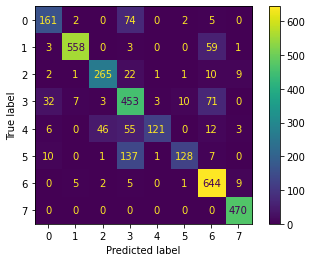

In [ ]:
from sklearn.metrics import plot_confusion_matrix

# confusion matrix
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

labels=y_test
classifier = estimator(best_model, classes=labels)
plot_confusion_matrix(estimator=classifier, X=x_test, y_true=y_test)